## **매개변수 갱신**

신경망 학습에서 매개변수의 최적값을 찾는 것, 즉 **최적화(optimization)**는 상당히 까다로운 문제이다.

그 방법 중 하나인 확률적 경사 하강법(Stochastic Gradient Descent : SGD)은 단순하지만, SGD보다 똑똑한 최적화 기법도 있다.

## **확률적 경사 하강법(SGD)**

In [1]:
import numpy

In [2]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, gards):
        for key in params.keys(): # SGD의 반복과정
            params[key] -= self.lr * grads[key]

SGD로 신경망 매개변수 진행 의사 코드


```
network = TwoLayerNet(...)
optimizer = SGD

for i in range(10000):
    ...
    x_batch, t_batch = get_mini_batch(...) # 미니배치
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params, grads)
    ...
```

optimizer가 매개변수 갱신을 책임지고 수행하므로, 우리는 optimizer에 매개변수와 기울기 정보만 넘겨주면 된다.

이처럼 최적화를 담당하는 클래스를 분리해 구현하면 기능을 모듈화하기 좋다.

## **SGD의 단점**

SGD는 단순하고 구현도 쉽지만, 문제에 따라서는 비효율적일 때가 있다.

언제 비효율 적인가?

$=>$ 비등방성(anisotropy)함수에서는 탐색 경로가 비효율적이다. 예를 들어 지그재그의 정도가 심하다.

* 비등방성 함수 : 방향에 따라 성질이 달라지는 함수

이러한 SGD의 단점을 개선해주는 방법에는 Momentum / AdaGrad / Adam 등이 있다.

## **Momentum**

모멘텀에서의 속도는 기울기 방향으로 힘을 받아 물체가 가속된다는 물리 법칙을 나타낸다.

In [3]:
# 모멘텀의 구현

class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None # 속도(velocity)

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

            for key in params.keys():
                self.v[key] = self.momentum * self.v[key] - self.lr * grads[key] # Momentum velocity 수식
                params[key] += self.v[key] # Momentum을 통해 매개변수를 갱신

모멘텀의 갱신 경로는 SGD와 비교하여 '지그재그 정도'가 덜하다. 

가속이라는 것이 존재하기 때문이다.

## **AdaGrad**

신경망 학습에서 학습률이 너무 작으면 학습시간이 길어지고, 너무 크면 발산하여 학습이 제대로 이뤄지지 않는다.

이 학습률을 정하는 효과적 기술로 **학습률 감소(learning rate decay)** 가 있다. 학습을 진행하면서 학습률을 점차 줄여가는 방법이다. 즉 처음에는 크게 학습하다가 조금씩 작게 학습한다.

AdaGrad는 개별 매개변수에 적응적으로(adaptive) 학습률을 조정하면서 학습을 진행한다.

AdaGrad는 과거의 기울기를 제곱하여 계속 더해가기 때문에, 학습을 진행할수록 갱신 강도가 약해지며 무한이 학습하면 갱신량이 0이 되어버린다.

이를 보완하기위해 RMSProp이라는 방법을 사용한다.

* RMSProp : 과거의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영한다.

In [4]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key] # h는 기존 기울기의 값을 제곱하여 더해준다
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # AdaGrad를 통해 매개변수를 갱신. 1e-7은 h에 0이 담겨있을때 0으로 나누는 사태를 막아준다.

AdaGrad는 최솟값을 향해 아주 효율적으로 움직인다. 지그재그 움직임은 거의 없고 쭉 하강하는 모습을 보인다.

축 방향의 큰 움직임에 비례해 갱신 정도도 큰 폭으로 작아지도록 조정된다.

## **Adam**

Momentum은 공이 그릇 바닥을 구르는 듯한 움직임을 보였다.
AdaGrad는 매개변수의 원소마다 적응적으로 갱신 정도를 조정하였다.

이 두기법을 융합한듯한 방법이 Adam이다.

매개변수 공간을 효율적으로 탐색해주며 하이퍼파라미터의 '편향 보정'이 진행된다.

<Adam의 구체적인 내용은 논문을 참고>

In [5]:
class Adam:

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

Adam 갱신 과정도 모멘텀 처럼 그릇 바닥을 구르듯 움직이며, 모멘텀 때보다 공의 좌우 흔들림이 적다.

이는 AdaGrad 처럼 학습의 갱신 강도를 적응적으로 조정해서 얻는 혜택이다.

## **어느 갱신 방법을 이용할 것인가?**

사실상 예시에서는 AdaGrad가 가장 나은 방법처럼 보이지만, 풀어야할 문제가 무엇인지, 하이퍼파라미터를 어떻게 설정하는지에 따라서 결과가 바뀐다.

따라서 SGD, Momentum, AdaGrad, Adam의 네 후보 중 항상 뛰어난 기법이라는 것은 없다. 상황에 따라서 잘 선택하는 것이 중요하다.

지금까지 많은 연구에서 SGD를 사용하고 있고, 요즈음은 Adam도 많이 사용한다.

## **MNIST 데이터셋으로 본 갱신 방법 비교**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


===========iteration:0===========
SGD:2.338082268603684
Momentum:2.447735862705559
AdaGrad:2.0882796809004933
Adam:2.2652407056027766
===========iteration:100===========
SGD:1.2465919047488696
Momentum:0.1777970724076726
AdaGrad:0.06542685586545348
Adam:0.19543105044026718
===========iteration:200===========
SGD:0.7874773978883587
Momentum:0.346416713132132
AdaGrad:0.15468413381738572
Adam:0.3158690135609799
===========iteration:300===========
SGD:0.47309896472654683
Momentum:0.12289918996943898
AdaGrad:0.07040035492818039
Adam:0.13407631237395168
===========iteration:400===========
SGD:0.4681635684296861
Momentum:0.3035913192190527
AdaGrad:0.08650437877476314
Adam:0.23009710387015003
===========iteration:500===========
SGD:0.352118585500071
Momentum:0.21343034702050828
AdaGrad:0.08275453102963429
Adam:0.1965612213885619
===========iteration:600===========
SGD:0.508162252603718
Momentum:0.18968799068741027
AdaGrad:0.06668838579978181
Adam:0.0959312460783288
===========iteration:700====

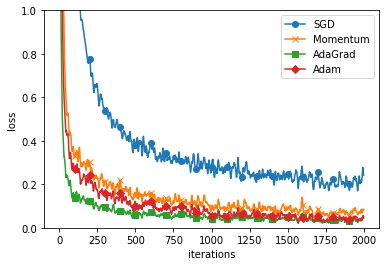

In [7]:
import sys
sys.path.append('/content/drive/MyDrive/밑바닥부터시작하는딥러닝/deep-learning-from-scratch-master')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

SGD의 학습 진도가 가장 느린것을 알 수 있다. 나머지 세 기법의 진도는 비슷해보이지만 AdaGrad가 조금 더 빠른것을 알 수 있다.

하지만 하이퍼파라미터와 신경망의 구조(층 깊이 등)에 따라 결과가 달라진다.

다만 일반적으로는 SGD보다 나머지 세 기법이 빠르게 학습하고, 정확도도 높게 나타난다.

## **가중치의 초깃값을 0으로 하면?**

신경망 학습에서 특히 중요한 것이 가중치의 초깃값이다.

오버피팅을 억제해 범용 성능을 높이는 테크닉인 **가중치 감소(weight decay)** 기법에서 출발하면, 가중치의 초깃값을 0으로 설정하는 것이 좋아보이지만 답부터 얘기하면 이는 나쁜아이디어다.

초깃값을 0으로 하면(정확히는 가중치를 균일한 값으로 설정해서는 안된다) 오차역전파법에서 모든 가중치의 값이 똑같이 갱신된다. 때문에 가중치의 갱신을 거쳐도 여전히 같은 값을 유지한다.

이렇게 가중치의 대칭적인 구조를 무너뜨리려면 초깃값을 무작위로 설정해야한다. 예를들어 정규분포에서 생성되는 값을 무작위로 선정한다 던지 말이다.

## **은닉층의 활성화값 분포**

활성화 함수로 시그모이드 함수를 사용하는 5층 신경망으로 가중치의 초깃값에 따른 은닉층 활성화값의 변화를 실험한다.

층이 5개가 잇으며, 각 층의 뉴런은 100개씩이다. 입력 데이터로서 1,000개의 데이터를 정규분포로 무작위로 생성하여 5층 신경망에 흘린다. 활성화 함수로 시그모이드 함수를 이용하고 각 층의 활성화 결과를 activations 변수에 저장한다. 가중치의 분포에 주의해야 하는데, 이번에는 표준편차가 1인 정규분포를 이용했으며 이 분포의 정도(표준편차)를 바꿔가며 활성화값들의 분포가 어떻게 변화하는지 관찰하는 것이 이 실험의 목적이다. 


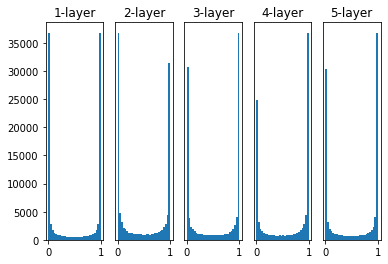

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

히스토그램을 확인해보니 각 층의 활성화값들이 0과 1에 치우쳐 분포되어 있음을 알 수 있다. 시그모이드 함수는 그 출력이 0에 가까워지자(또는 1에가까워지자) 그 미분은 0에 다가간다. 따라서 역전파의 기울기 값이 점점 작아지다가 사라진다.

이것이 **기울기 소실(gradient vanishing)**이라 알려진 문제이다. 층을 깊게 하는 딥러닝에서는 기울기 소실은 더욱 심각한 문제가 될 수 있다.

이번에는 가중치의 표준편차를 0.01로 바꿔 같은 실험을 반복한다.

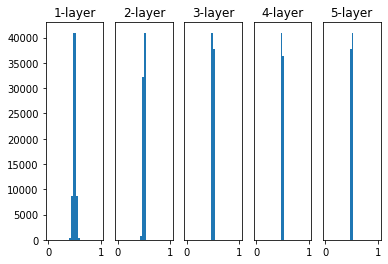

In [9]:
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    # w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

표준편차를 0.01로 한 정규분포의 경우 0.5부근에 활성화값 분포가 집중된것을 알 수 있다. 이러한 경우네는 기울기 소실 문제는 일어나지 않지만, 활성화값들이 치우쳤다는 점에서 표현력 관점에서는 큰 문제가 있다.

즉 이상황에서는 다수의 뉴런이 거의 같은 값을 출력하고 있으니 뉴런을 여러 개 둔 의미가 없어진다는 뜻이다.

따라서 활성화값들이 치우치면 **표현력을 제한** 한다는 관점에서 문제가 된다. 신경망 학습이 효율적으로 이뤄지지 않는다.

이번에는 일반적인 딥러닝 프레임워크들이 표준적으로 이용하는 **Xavier 초깃값**을 사용해보자.

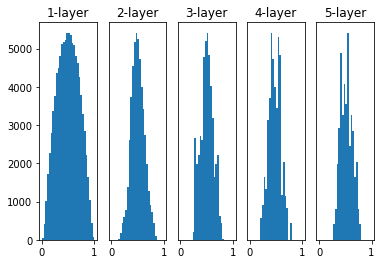

In [10]:
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
    # w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num) # Xavier 초깃값 (앞 계층의 노드가 n개라면 표준편차가 1/sqrt(n)이 되도록 설정)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

Xavier 초깃값을 사용한 각 층의 활성화값 분포 결과를 보면 층이 깊어지면서 형태는 다소 일그러지지만, 앞에서 본 방식보다는 확실히 넓게 분포됨을 알 수 있다.

각 층에 흐르는 데이터는 적당히 퍼져 있으므로, 시그모이드 함수의 표현력도 제한받지 않고 학습이 효율적으로 이뤄질 것으로 기대된다. 

## **ReLU를 사용할 때의 가중치 초깃값**

논문에서는 Xavier 초깃값은 활성화 함수가 선형인 것을 전제로 이끈 결과이다. sigmoid함수와 tanh 함수는 좌우 대칭이라 중앙 부근이 선형인 함수로 볼 수 있기 때문에 Xavier 초깃값이 적당하다.

하지만 ReLU를 이용할 때는 ReLU에 특화된 초깃값을 이용하라고 권장한다. 이 특화된 초깃값을 **He 초깃값**이라 한다.

He 초깃값은 앞 계층의 노드가 $n$개일 때, 표준편차가 $\sqrt{\frac{2}{n}}$인 정규분포를 사용한다. Xavier 초깃값 $\sqrt{\frac{1}{n}}$에 비해 ReLU는 음의 영역이 0이라서 더 넓게 분포시키기 위해 2배의 계수가 필요하다고 해석할 수 있다.

이제 활성화 함수로 ReLU를 이용한 경우의 활성화값 분포를 보자.

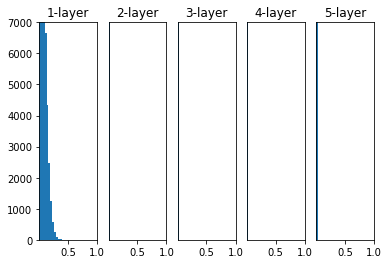

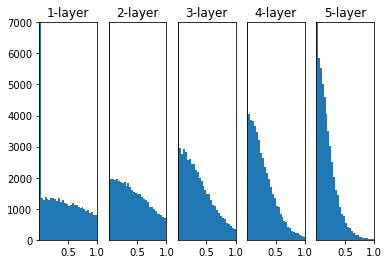

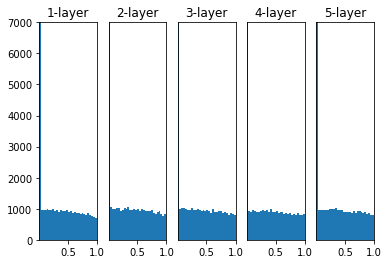

In [15]:
node_num = 100

w_sigma = np.random.randn(node_num, node_num) * 0.01
w_Xavier = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num) 
w_He = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
W = [w_sigma, w_Xavier, w_He]

for w in W: 
    input_data = np.random.randn(1000, 100)  # 1000개의 데이터
    node_num = 100  # 각 은닉층의 노드(뉴런) 수
    hidden_layer_size = 5  # 은닉층이 5개
    activations = {}  # 이곳에 활성화 결과를 저장

    x = input_data

    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]

        a = np.dot(x, w)

        # 활성화 함수도 바꿔가며 실험해보자！
        # z = sigmoid(a)
        z = ReLU(a)
        # z = tanh(a)

        activations[i] = z

    # 히스토그램 그리기
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer")
        if i != 0: plt.yticks([], [])
        plt.xlim(0.01, 1)
        plt.ylim(0, 7000)
        plt.hist(a.flatten(), 30, range=(0,1))
    plt.show()

첫째로, 표준편차 0.01인 정규분포를 가중치 초깃값으로 사용한 경우 각 층의 활성화 값들이 아주 작은 값들이다. 신경망에 아주 작은 데이터가 흐른다는 것은 역전파 때 가중치의 기울기 역시 작아진다는 뜻이다. 

둘째로, Xavier 초깃값 결과를 보면 층이 깊어지면서 치우침이 조금씩 커진다. 실제로 층이 깊어지면 활성화값들의 치우침도 커지고, 학습할 때 '기울기 소실'문제를 일으킨다.

마지막으로, He 초깃값은 모든 층에서 균일하게 분포되었다. 층이 깊어져도 분포가 균일하게 유지되기에 역전파 때도 적절한 값이 나올 것으로 기대할 수 있다.

이상의 실험 결과를 바탕으로, 정리를 하면 다음과 같다.

* 활성화함수가 ReLU $=>$ He 초깃값
* 활성화함수가 sigmoid, tanh등 S자 모양 곡선 $=>$ Xavier 초깃값

## **MNIST 데이터셋으로 본 가중치 초깃값 비교**

===========iteration:0===========
std=0.01:2.302532898596142
Xavier:2.304559812875306
He:2.4269149474873277
===========iteration:100===========
std=0.01:2.3019823956888876
Xavier:2.1891441740425446
He:1.224036279394901
===========iteration:200===========
std=0.01:2.3034652471476598
Xavier:2.020166274175682
He:0.6780623742987302
===========iteration:300===========
std=0.01:2.3009341091915423
Xavier:1.5714655608821906
He:0.44742007029501235
===========iteration:400===========
std=0.01:2.3043109793426284
Xavier:1.0447650147843288
He:0.40863467795430075
===========iteration:500===========
std=0.01:2.305562073161667
Xavier:0.8147050702104708
He:0.6148947776135154
===========iteration:600===========
std=0.01:2.3033765840153864
Xavier:0.6284304974945883
He:0.41414276358904073
===========iteration:700===========
std=0.01:2.3026555329374716
Xavier:0.4321650514049519
He:0.26182899880285015
===========iteration:800===========
std=0.01:2.2967547412601617
Xavier:0.4484347417090574
He:0.414738313726

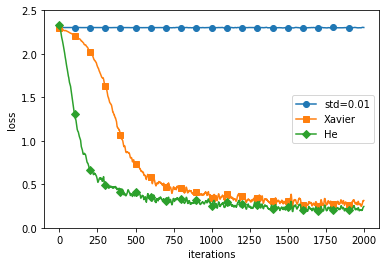

In [16]:
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

std=0.01 일 때는 학습이 전혀 이뤄지지 않는다. 순전파 때 너무 작은 값(0 근처로 밀집한 데이터)이 흐르기 때문이다. 그로 인해 역전파 때의 기울기도 작아져 가중치가 거의 갱신되지 않는 것이다.

반대로 Xavier와 He 초깃값의 경우는 학습이 순조롭게 이뤄지고 있지만, 학습 진도는 He 초깃값 쪽이 더 빠른 것을 알 수 있다. 활성화 함수가 ReLU 이기 때문이라고 할 수 있다.

이처럼 초깃값에 따라 신경망 학습의 성패가 갈리는 경우가 많으므로 가중치 초깃값 설정을 잘 하는것이 중요하다.

## **배치 정규화 알고리즘**

앞서 가중치의 초깃값을 적절히 설정하여 각 층의 활성화값 분포를 적당히 퍼지게 하였는데, 각 층이 활성화를 적당히 퍼뜨리도록 '강제'하는것이 **배치 정규화(Batch Normalization)**의 아이디어다.

배치 정규화가 주목받는 이유는 다음과 같다.
* 학습을 빨리 진행할 수 있다(학습속도 개선).
* 초깃값에 크게 의존하지 않는다(골치 아픈 초깃값 선택 장애X).
* 오버피팅을 억제한다(드롭아웃 등의 필요성 감소).

<배치 정규화를 사용한 신경망의 예>

INPUT $\rightarrow$ Affine $\rightarrow$ **Batch Norm** $\rightarrow$ ReLU $\Rightarrow$ Affine $\rightarrow$ **Batch Norm** $\rightarrow$ ReLU $\Rightarrow$ Affine $\rightarrow$ Softmax $\Rightarrow$ OUTPUT


배치 정규화는 그 이름과 같이 학습 시 미니배치를 단위로 정규화한다.
구체적으로 데이터 분포가 평균이0, 분산이 1이 되도록 정규화한다.

또, 배치 정규화 계층마다 이 정규화된 데이터에 고유한 확대(scale)와 이동(shift) 변환을 수행한다. 수식으로는 다음과 같다.

$$y_i \leftarrow \gamma\hat{x_i} + \beta$$



## **배치 정규화의 효과**

============== 1/16 ==============
epoch:0 | 0.087 - 0.101


/content/drive/MyDrive/밑바닥부터시작하는딥러닝/deep-learning-from-scratch-master/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/content/drive/MyDrive/밑바닥부터시작하는딥러닝/deep-learning-from-scratch-master/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/content/drive/MyDrive/밑바닥부터시작하는딥러닝/deep-learning-from-scratch-master/common/functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:1 | 0.097 - 0.125
epoch:2 | 0.097 - 0.126
epoch:3 | 0.097 - 0.149
epoch:4 | 0.097 - 0.172
epoch:5 | 0.097 - 0.2
epoch:6 | 0.097 - 0.217
epoch:7 | 0.097 - 0.24
epoch:8 | 0.097 - 0.252
epoch:9 | 0.097 - 0.267
epoch:10 | 0.097 - 0.285
epoch:11 | 0.097 - 0.312
epoch:12 | 0.097 - 0.325
epoch:13 | 0.097 - 0.333
epoch:14 | 0.097 - 0.347
epoch:15 | 0.097 - 0.367
epoch:16 | 0.097 - 0.376
epoch:17 | 0.097 - 0.399
epoch:18 | 0.097 - 0.405


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.437
============== 2/16 ==============
epoch:0 | 0.099 - 0.128


/content/drive/MyDrive/밑바닥부터시작하는딥러닝/deep-learning-from-scratch-master/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/content/drive/MyDrive/밑바닥부터시작하는딥러닝/deep-learning-from-scratch-master/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.13
epoch:2 | 0.097 - 0.156
epoch:3 | 0.097 - 0.169
epoch:4 | 0.097 - 0.201
epoch:5 | 0.097 - 0.23
epoch:6 | 0.097 - 0.255
epoch:7 | 0.097 - 0.271
epoch:8 | 0.097 - 0.302
epoch:9 | 0.097 - 0.325
epoch:10 | 0.097 - 0.342
epoch:11 | 0.097 - 0.361
epoch:12 | 0.097 - 0.376
epoch:13 | 0.097 - 0.404
epoch:14 | 0.097 - 0.428
epoch:15 | 0.097 - 0.443
epoch:16 | 0.097 - 0.453
epoch:17 | 0.097 - 0.468
epoch:18 | 0.097 - 0.477


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.502
============== 3/16 ==============
epoch:0 | 0.092 - 0.1
epoch:1 | 0.317 - 0.119
epoch:2 | 0.434 - 0.153
epoch:3 | 0.507 - 0.192
epoch:4 | 0.587 - 0.23
epoch:5 | 0.634 - 0.258
epoch:6 | 0.67 - 0.292
epoch:7 | 0.71 - 0.314
epoch:8 | 0.749 - 0.348
epoch:9 | 0.778 - 0.394
epoch:10 | 0.814 - 0.419
epoch:11 | 0.831 - 0.439
epoch:12 | 0.853 - 0.463
epoch:13 | 0.871 - 0.493
epoch:14 | 0.884 - 0.512
epoch:15 | 0.888 - 0.533
epoch:16 | 0.903 - 0.555
epoch:17 | 0.914 - 0.57
epoch:18 | 0.919 - 0.6


No handles with labels found to put in legend.


epoch:19 | 0.932 - 0.612
============== 4/16 ==============
epoch:0 | 0.064 - 0.096
epoch:1 | 0.187 - 0.143
epoch:2 | 0.341 - 0.215
epoch:3 | 0.438 - 0.289
epoch:4 | 0.534 - 0.357
epoch:5 | 0.592 - 0.405
epoch:6 | 0.625 - 0.465
epoch:7 | 0.656 - 0.498
epoch:8 | 0.7 - 0.531
epoch:9 | 0.734 - 0.556
epoch:10 | 0.739 - 0.594
epoch:11 | 0.747 - 0.626
epoch:12 | 0.772 - 0.641
epoch:13 | 0.78 - 0.66
epoch:14 | 0.799 - 0.687
epoch:15 | 0.816 - 0.704
epoch:16 | 0.815 - 0.722
epoch:17 | 0.843 - 0.73
epoch:18 | 0.848 - 0.742


No handles with labels found to put in legend.


epoch:19 | 0.863 - 0.751
============== 5/16 ==============
epoch:0 | 0.095 - 0.1
epoch:1 | 0.097 - 0.147
epoch:2 | 0.105 - 0.269
epoch:3 | 0.125 - 0.436
epoch:4 | 0.134 - 0.538
epoch:5 | 0.145 - 0.604
epoch:6 | 0.165 - 0.644
epoch:7 | 0.18 - 0.679
epoch:8 | 0.195 - 0.72
epoch:9 | 0.209 - 0.751
epoch:10 | 0.223 - 0.764
epoch:11 | 0.238 - 0.785
epoch:12 | 0.239 - 0.796
epoch:13 | 0.251 - 0.82
epoch:14 | 0.254 - 0.837
epoch:15 | 0.27 - 0.847
epoch:16 | 0.266 - 0.861
epoch:17 | 0.282 - 0.873
epoch:18 | 0.29 - 0.881


No handles with labels found to put in legend.


epoch:19 | 0.291 - 0.883
============== 6/16 ==============
epoch:0 | 0.074 - 0.071
epoch:1 | 0.091 - 0.243
epoch:2 | 0.132 - 0.454
epoch:3 | 0.12 - 0.583
epoch:4 | 0.12 - 0.651
epoch:5 | 0.117 - 0.702
epoch:6 | 0.117 - 0.74
epoch:7 | 0.117 - 0.771
epoch:8 | 0.119 - 0.793
epoch:9 | 0.117 - 0.813
epoch:10 | 0.117 - 0.837
epoch:11 | 0.117 - 0.85
epoch:12 | 0.163 - 0.869
epoch:13 | 0.117 - 0.876
epoch:14 | 0.117 - 0.893
epoch:15 | 0.117 - 0.906
epoch:16 | 0.117 - 0.912
epoch:17 | 0.117 - 0.926
epoch:18 | 0.117 - 0.933


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.943
============== 7/16 ==============
epoch:0 | 0.117 - 0.103
epoch:1 | 0.116 - 0.353
epoch:2 | 0.116 - 0.564
epoch:3 | 0.116 - 0.655
epoch:4 | 0.116 - 0.703
epoch:5 | 0.116 - 0.746
epoch:6 | 0.116 - 0.782
epoch:7 | 0.116 - 0.818
epoch:8 | 0.116 - 0.852
epoch:9 | 0.116 - 0.888
epoch:10 | 0.116 - 0.912
epoch:11 | 0.116 - 0.924
epoch:12 | 0.18 - 0.942
epoch:13 | 0.117 - 0.949
epoch:14 | 0.192 - 0.952
epoch:15 | 0.117 - 0.967
epoch:16 | 0.117 - 0.97
epoch:17 | 0.117 - 0.975
epoch:18 | 0.117 - 0.982


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.986
============== 8/16 ==============
epoch:0 | 0.094 - 0.112
epoch:1 | 0.116 - 0.458
epoch:2 | 0.116 - 0.713
epoch:3 | 0.116 - 0.773
epoch:4 | 0.116 - 0.839
epoch:5 | 0.116 - 0.876
epoch:6 | 0.116 - 0.929
epoch:7 | 0.116 - 0.948
epoch:8 | 0.116 - 0.965
epoch:9 | 0.116 - 0.978
epoch:10 | 0.116 - 0.987
epoch:11 | 0.116 - 0.99
epoch:12 | 0.116 - 0.991
epoch:13 | 0.116 - 0.997
epoch:14 | 0.116 - 0.999
epoch:15 | 0.116 - 0.998
epoch:16 | 0.116 - 0.999
epoch:17 | 0.116 - 0.999
epoch:18 | 0.116 - 0.999


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.999
============== 9/16 ==============
epoch:0 | 0.116 - 0.137
epoch:1 | 0.116 - 0.513
epoch:2 | 0.116 - 0.747
epoch:3 | 0.116 - 0.823
epoch:4 | 0.116 - 0.881
epoch:5 | 0.116 - 0.931
epoch:6 | 0.116 - 0.961
epoch:7 | 0.116 - 0.978
epoch:8 | 0.116 - 0.981
epoch:9 | 0.116 - 0.989
epoch:10 | 0.116 - 0.993
epoch:11 | 0.116 - 0.995
epoch:12 | 0.116 - 0.997
epoch:13 | 0.116 - 0.997
epoch:14 | 0.116 - 0.998
epoch:15 | 0.116 - 0.998
epoch:16 | 0.116 - 0.999
epoch:17 | 0.116 - 1.0
epoch:18 | 0.116 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.116 - 1.0
============== 10/16 ==============
epoch:0 | 0.094 - 0.107
epoch:1 | 0.117 - 0.597
epoch:2 | 0.116 - 0.683
epoch:3 | 0.116 - 0.707
epoch:4 | 0.116 - 0.733
epoch:5 | 0.116 - 0.738
epoch:6 | 0.116 - 0.796
epoch:7 | 0.116 - 0.807
epoch:8 | 0.116 - 0.851
epoch:9 | 0.116 - 0.963
epoch:10 | 0.116 - 0.969
epoch:11 | 0.116 - 0.987
epoch:12 | 0.116 - 0.994
epoch:13 | 0.116 - 0.994
epoch:14 | 0.116 - 0.994
epoch:15 | 0.116 - 0.968
epoch:16 | 0.116 - 0.993
epoch:17 | 0.116 - 0.996
epoch:18 | 0.116 - 0.997


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.998
============== 11/16 ==============
epoch:0 | 0.117 - 0.19
epoch:1 | 0.117 - 0.646
epoch:2 | 0.117 - 0.709
epoch:3 | 0.117 - 0.764
epoch:4 | 0.117 - 0.624
epoch:5 | 0.116 - 0.752
epoch:6 | 0.116 - 0.795
epoch:7 | 0.116 - 0.784
epoch:8 | 0.116 - 0.866
epoch:9 | 0.116 - 0.885
epoch:10 | 0.116 - 0.892
epoch:11 | 0.116 - 0.895
epoch:12 | 0.116 - 0.897
epoch:13 | 0.116 - 0.892
epoch:14 | 0.116 - 0.896
epoch:15 | 0.116 - 0.896
epoch:16 | 0.116 - 0.897
epoch:17 | 0.116 - 0.897
epoch:18 | 0.117 - 0.897


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.898
============== 12/16 ==============
epoch:0 | 0.097 - 0.097
epoch:1 | 0.116 - 0.666
epoch:2 | 0.116 - 0.622
epoch:3 | 0.116 - 0.674
epoch:4 | 0.116 - 0.684
epoch:5 | 0.116 - 0.638
epoch:6 | 0.116 - 0.776
epoch:7 | 0.116 - 0.802
epoch:8 | 0.116 - 0.808
epoch:9 | 0.116 - 0.793
epoch:10 | 0.116 - 0.803
epoch:11 | 0.116 - 0.838
epoch:12 | 0.116 - 0.881
epoch:13 | 0.116 - 0.89
epoch:14 | 0.116 - 0.877
epoch:15 | 0.116 - 0.895
epoch:16 | 0.116 - 0.896
epoch:17 | 0.116 - 0.902
epoch:18 | 0.116 - 0.902


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.824
============== 13/16 ==============
epoch:0 | 0.117 - 0.112
epoch:1 | 0.105 - 0.433
epoch:2 | 0.117 - 0.44
epoch:3 | 0.117 - 0.568
epoch:4 | 0.117 - 0.678
epoch:5 | 0.117 - 0.668
epoch:6 | 0.117 - 0.68
epoch:7 | 0.117 - 0.7
epoch:8 | 0.117 - 0.701
epoch:9 | 0.117 - 0.67
epoch:10 | 0.117 - 0.709
epoch:11 | 0.117 - 0.71
epoch:12 | 0.117 - 0.712
epoch:13 | 0.117 - 0.712
epoch:14 | 0.117 - 0.715
epoch:15 | 0.117 - 0.714
epoch:16 | 0.117 - 0.715
epoch:17 | 0.117 - 0.714
epoch:18 | 0.117 - 0.71


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.716
============== 14/16 ==============
epoch:0 | 0.116 - 0.174
epoch:1 | 0.117 - 0.495
epoch:2 | 0.117 - 0.488
epoch:3 | 0.117 - 0.499
epoch:4 | 0.117 - 0.507
epoch:5 | 0.117 - 0.564
epoch:6 | 0.117 - 0.601
epoch:7 | 0.117 - 0.581
epoch:8 | 0.117 - 0.586
epoch:9 | 0.117 - 0.607
epoch:10 | 0.117 - 0.617
epoch:11 | 0.117 - 0.615
epoch:12 | 0.117 - 0.592
epoch:13 | 0.117 - 0.619
epoch:14 | 0.117 - 0.619
epoch:15 | 0.116 - 0.621
epoch:16 | 0.116 - 0.62
epoch:17 | 0.116 - 0.608
epoch:18 | 0.116 - 0.625


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.623
============== 15/16 ==============
epoch:0 | 0.105 - 0.154
epoch:1 | 0.117 - 0.306
epoch:2 | 0.117 - 0.466
epoch:3 | 0.117 - 0.486
epoch:4 | 0.117 - 0.494
epoch:5 | 0.117 - 0.496
epoch:6 | 0.116 - 0.5
epoch:7 | 0.116 - 0.473
epoch:8 | 0.116 - 0.51
epoch:9 | 0.116 - 0.512
epoch:10 | 0.116 - 0.507
epoch:11 | 0.116 - 0.514
epoch:12 | 0.116 - 0.571
epoch:13 | 0.116 - 0.558
epoch:14 | 0.116 - 0.584
epoch:15 | 0.116 - 0.594
epoch:16 | 0.116 - 0.214
epoch:17 | 0.116 - 0.564
epoch:18 | 0.116 - 0.592


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.595
============== 16/16 ==============
epoch:0 | 0.097 - 0.097
epoch:1 | 0.116 - 0.314
epoch:2 | 0.116 - 0.322
epoch:3 | 0.116 - 0.319
epoch:4 | 0.116 - 0.323
epoch:5 | 0.116 - 0.325
epoch:6 | 0.116 - 0.324
epoch:7 | 0.116 - 0.327
epoch:8 | 0.116 - 0.329
epoch:9 | 0.116 - 0.33
epoch:10 | 0.116 - 0.331
epoch:11 | 0.116 - 0.434
epoch:12 | 0.116 - 0.43
epoch:13 | 0.116 - 0.433
epoch:14 | 0.116 - 0.431
epoch:15 | 0.116 - 0.431
epoch:16 | 0.116 - 0.43
epoch:17 | 0.117 - 0.435
epoch:18 | 0.117 - 0.434
epoch:19 | 0.117 - 0.434


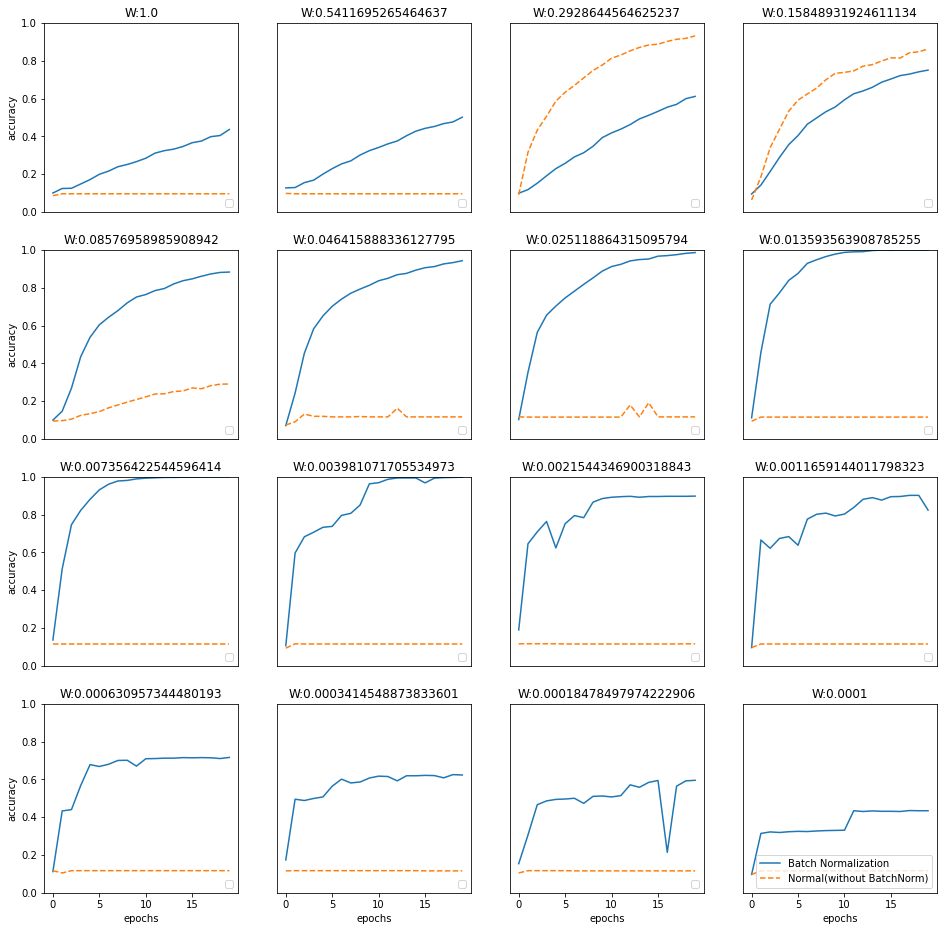

In [19]:
# 배치 정규화 계층을 사용한 실험

from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

plt.figure(figsize=(16,16))

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

거의 모든 경우에서 배치 정규화를 사용할 때의 학습진도가 빠른것을 알 수 있다. 실제로 배치 정규화를 이용하지 않는 경우에는 초깃값이 잘 분포되어 있지 않으면 학습이 전혀 진행되지 않는 경우도 있는것을 알 수 있다.

이처럼 배치 정규화를 사용하면 학습이 빨라지며, 가중치 초깃값에 크게 의존하지 않아도 되는 등 장점이 많으니 앞으로 다양한 곳에서 사용한다.

## **오버피팅**

오버피팅은 주로 다음의 두 경우에 일어난다.

* 매개변수가 많고 표현력이 높은 모델
* 훈련 데이터가 적음

일부러 이 두 요건을 충족시켜 오버피팅을 일으켜보자.

epoch:0, train acc:0.13333333333333333, test acc:0.117
epoch:1, train acc:0.15333333333333332, test acc:0.1293
epoch:2, train acc:0.17, test acc:0.1485
epoch:3, train acc:0.2, test acc:0.163
epoch:4, train acc:0.21333333333333335, test acc:0.1794
epoch:5, train acc:0.23666666666666666, test acc:0.1925
epoch:6, train acc:0.26, test acc:0.2062
epoch:7, train acc:0.28, test acc:0.2226
epoch:8, train acc:0.3, test acc:0.2366
epoch:9, train acc:0.3233333333333333, test acc:0.2505
epoch:10, train acc:0.33666666666666667, test acc:0.2686
epoch:11, train acc:0.36666666666666664, test acc:0.2767
epoch:12, train acc:0.37, test acc:0.2883
epoch:13, train acc:0.39, test acc:0.2954
epoch:14, train acc:0.4166666666666667, test acc:0.306
epoch:15, train acc:0.43, test acc:0.3149
epoch:16, train acc:0.45666666666666667, test acc:0.3336
epoch:17, train acc:0.45, test acc:0.3385
epoch:18, train acc:0.47, test acc:0.3521
epoch:19, train acc:0.5033333333333333, test acc:0.3589
epoch:20, train acc:0.526666

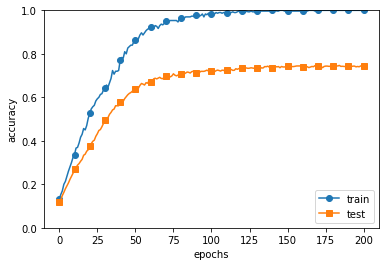

In [21]:
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감소） 설정 =======================
weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
# weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

그래프를 확인해보면 훈련 데이터는 100에폭을 지나는 무렵부터 거의 정확도가 100%인데, 시험 데이터에 대해서는 큰 차이를 보인다. 

훈련 때 사용하지 않은 범용 데이터(시험 데이터)에는 제대로 대응하지 못하는 것을 이 그래프에서 확인할 수 있다.

## **가중치 감소(weight decay)**

오버피팅 억제용으로 예로부터 많이 이용해온 방법 중 **가중치 감소(weight decay)**라는 것이 있다.

원래 오버피팅은 가중치 매개변수의 값이 커서 발생하는 경우가 많기 때문에, 학습 과정에서 큰 가중치에 대해서는 그에 상응하는 큰 페널티를 부과하여 오버피팅을 억제하는 방법이다.

예를 들어 가중치의 L2 norm 을 손실함수에 더하면, 신경망 학습의 목적은 손실 함수의 값을 줄이는 것이기 때문에 가중치가 커지는 것을 억제할 수 있다.

여기서 가중치 감소 $\frac{1}{2}\lambda W^2$의 $\lambda$는 정규화의 세기를 조절하는 하이퍼파라미터이다.

epoch:0, train acc:0.09333333333333334, test acc:0.0596
epoch:1, train acc:0.1, test acc:0.0716
epoch:2, train acc:0.12, test acc:0.0819
epoch:3, train acc:0.13333333333333333, test acc:0.0965
epoch:4, train acc:0.15, test acc:0.109
epoch:5, train acc:0.18333333333333332, test acc:0.1206
epoch:6, train acc:0.20666666666666667, test acc:0.1372
epoch:7, train acc:0.22666666666666666, test acc:0.151
epoch:8, train acc:0.25, test acc:0.1658
epoch:9, train acc:0.27, test acc:0.1748
epoch:10, train acc:0.29333333333333333, test acc:0.1906
epoch:11, train acc:0.32666666666666666, test acc:0.204
epoch:12, train acc:0.3433333333333333, test acc:0.2229
epoch:13, train acc:0.3566666666666667, test acc:0.2362
epoch:14, train acc:0.36, test acc:0.2422
epoch:15, train acc:0.38666666666666666, test acc:0.256
epoch:16, train acc:0.4266666666666667, test acc:0.2774
epoch:17, train acc:0.44333333333333336, test acc:0.3009
epoch:18, train acc:0.45, test acc:0.2977
epoch:19, train acc:0.4533333333333333, 

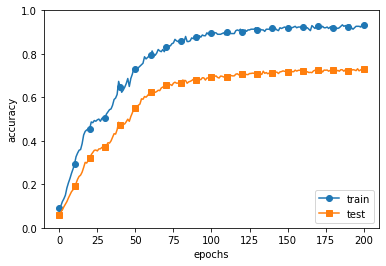

In [22]:
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감소） 설정 =======================
# weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

어쩔 수 없이 훈련 데이터에 대한 정확도와 시험 데이터에 대한 정확도에는 여전히 차이가 있지만, 가중치 감소를 사용하지 않은 경우와 비교했을때 그 차이가 확연히 줄었다. 즉 오버피팅이 억제됐다.

앞서와 달리 훈련 데이터에 대한 정확도가 100%에 도달하지 못한 점도 주목해야 한다.

## **드롭아웃**

신경망 모델이 복잡해지면 가중치 감소만으로는 대응하기 어려우므로, **드롭아웃(Dropout)** 기법을 이용한다.

드롭아웃은 뉴런을 임의로 삭제하면서 학습하는 방법이다.

훈련 때 은닉층의 뉴런을 무작위로 골라 삭제한다. 훈련때는 데이터를 흘릴 때마다 삭제할 뉴런을 무작위로 선택하고, 시험 때는 모든 뉴런에 신호를 전달한다. 단, 시험 때는 각 뉴런의 출력에 훈련 때 삭제 안 한 비율을 곱하여 출력한다.

이제 드롭아웃을 구현해보자.

train loss:2.2845490048217787
=== epoch:1, train acc:0.13333333333333333, test acc:0.1503 ===
train loss:2.291922990474862
train loss:2.297865192267144
train loss:2.288696941772299
=== epoch:2, train acc:0.13333333333333333, test acc:0.1523 ===
train loss:2.285654670922508
train loss:2.282680542002976
train loss:2.2863525157209823
=== epoch:3, train acc:0.13333333333333333, test acc:0.1524 ===
train loss:2.276353862945775
train loss:2.2813610947740632
train loss:2.284440423037125
=== epoch:4, train acc:0.13333333333333333, test acc:0.1549 ===
train loss:2.291409570349412
train loss:2.2951980388146542
train loss:2.281805986894567
=== epoch:5, train acc:0.13666666666666666, test acc:0.1555 ===
train loss:2.2936587953703858
train loss:2.2954069724155035
train loss:2.2890719295687285
=== epoch:6, train acc:0.13333333333333333, test acc:0.1565 ===
train loss:2.2763458458773993
train loss:2.310597045973467
train loss:2.2877878837161405
=== epoch:7, train acc:0.13666666666666666, test acc:0.1

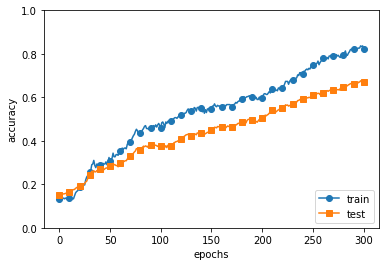

In [23]:
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

드롭아웃을 적용하니 훈련 데이터와 시험 데이터에 대한 정확도 차이가 확연히 줄었다. 또한 훈련 데이터에 대한 정확도가 100%에 도달하지 않게 되었다.

이처럼 드롭아웃을 이용하면 표현력을 높이면서도 오버피팅을 억제할 수 있다.

기계학습에서 앙상블 학습과 마찬가지로, 드롭아웃이 학습 때 뉴런을 무작위로 삭제하는 행위를 매번 다른 모델을 학습시키는것으로 해석할 수 있기 때문에
드롭아웃은 앙상블 학습과 같은 효과를 대략 하나의 네트워크로 구현했다고 생각할 수 있다.

## **적절한 하이퍼파라미터 값 찾기 - 검증데이터**

적절한 하이퍼파라미터 값을 찾을 때, 하이퍼파라미터의 성능을 시험 데이터를 사용하여 평가하면 안되는 것에 주의해야 한다.

시험 데이터를 사용하여 하이퍼파라미터를 조정하면 하이퍼파라미터 값이 시험데이터에 오버피팅되기 때문이다. 따라서 범용 성능이 떨어지는 모델이 된다.

따라서 **검증 데이터(validation data)** 라고 하는 하이퍼파라미터 전용 확인 데이터가 필요하다.

정리를 해보자.
* 훈련 데이터 : 매개변수 학습
* 검증 데이터 : 하이퍼파라미터 성능 평가
* 시험 데이터 : 신경망의 범용 성능 평가

검증 데이터를 얻는 가장 간단한 방법은 훈련 데이터 중 20% 정도를 검증 데이터로 먼저 분리하는 것이다. 코드로 구현해보자.

```
def shuffle_dataset(x, t):
    """데이터셋을 뒤섞는다.
    Parameters
    ----------
    x : 훈련 데이터
    t : 정답 레이블
    
    Returns
    -------
    x, t : 뒤섞은 훈련 데이터와 정답 레이블
    """
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

    return x, t

(x_train, t_train), (x_test, t_test) = load_mnist()

# 훈련 데이터를 뒤섞는다.
x_train, t_train = shuffle_dataset(x_train, t_train)

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[valdiation_num:]
t_train = t_train[validaiton_num:]
```

## **하이퍼파라미터 최적화**

하이퍼파라미터를 최적할 때의 핵심은 하이퍼파라미터의 '최적 값'이 존재하는 범위를 조금씩 줄여가는 것이다. 범위를 조금씩 줄이려면 우선 대략적인 범위를 설정하고 그 범위에서 무작위로 하이퍼파라미터 값을 샘플링 후, 그 값으로 정확도를 평가한다. 정확도를 잘 살피면서 이 작업을 여러 번 반복하며 하이퍼파라미터의 '최적 값'의 범위를 좁혀가는 것이다. 신경망의 하이퍼파라미터 최적화에서는 그리드서치(grid search)같은 규칙적인 탐색보다는 무작위로 샘플링해 탐색하는 편이 좋다고 알려져있다.

딥러닝 학습에서 하이퍼파라미터를 최적화할 때는 오랜 시간(예컨대 며칠이나 몇 주 이상)이 걸리기 때문에, 나쁠 듯한 값은 일찍 포기하고 학습을 위한 에폭을 작게 하여, 1회 평가에 걸리는 시간을 단축하는 것이 효과적이다.

과정을 정리해보자.

* 0단계

    하이퍼파라미터 값의 범위를 설정한다.
* 1단계

    설정된 범위에서 하이퍼파라미터의 값을 무작위로 추출한다.
* 2단계

    1단계에서 샘플링한 하이퍼파라미터 값을 사용하여 학습하고, 검증 데이터로 정확도를 평가한다(단, 에폭은 작게 설정한다).
* 3단계

    1단계와 2단계를 특정 횟수(100회 등) 반복하며, 그 정확도의 결과를 보고 하이퍼파라미터의 범위를 좁힌다.

이 과정은 과학이라기 보다는 수행자의 '지혜'와 '직관'에 의존한다. 조금 더 세련된 기법을 원하면 **베이즈 최적화(Bayesian optimization)**을 참고하자.

## **하이퍼파라미터 최적화 구현하기**

val acc:0.18 | lr:0.0010219997731253012, weight decay:2.9903735627123765e-08
val acc:0.1 | lr:0.000309656618666526, weight decay:3.936760990349588e-06
val acc:0.08 | lr:1.269737808912207e-06, weight decay:6.514685383686731e-06
val acc:0.09 | lr:7.265479671208562e-06, weight decay:7.560088118392122e-08
val acc:0.13 | lr:0.00034364814315131074, weight decay:4.102005286029143e-06
val acc:0.1 | lr:5.888044731923168e-05, weight decay:1.0570065935133518e-06
val acc:0.09 | lr:6.033024969416848e-05, weight decay:1.7766352513650122e-05
val acc:0.15 | lr:6.663999389424055e-05, weight decay:5.0917065632247865e-06
val acc:0.21 | lr:0.00023511502438552462, weight decay:3.4309527129391884e-07
val acc:0.13 | lr:0.0003540209852371263, weight decay:6.296236350492459e-05
val acc:0.13 | lr:4.1499262706359674e-05, weight decay:3.037967638471627e-06
val acc:0.23 | lr:0.0004844381055342967, weight decay:2.420753646888857e-08
val acc:0.15 | lr:0.0005826320751210047, weight decay:3.203380645917343e-08
val acc

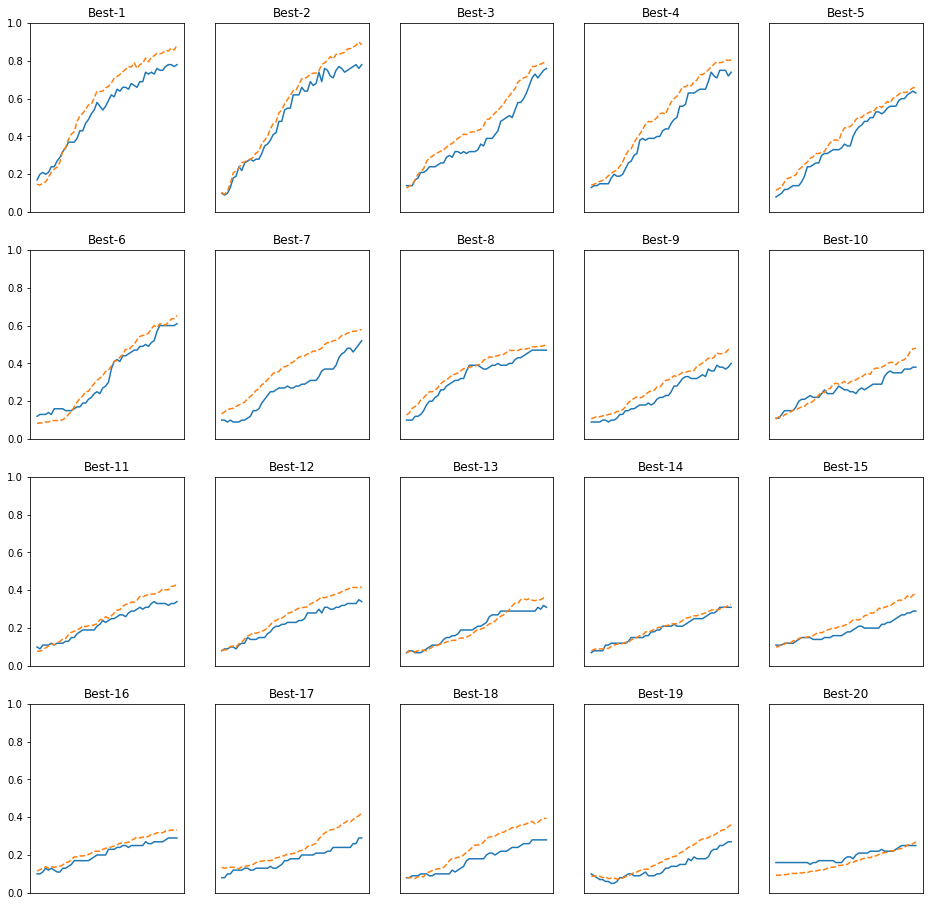

In [24]:
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

plt.figure(figsize=(16,16))
for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

검증 데이터의 학습 추이를 정확도가 높은 순서로 나열 했는데, 'Best-5'정도까지는 학습이 순조롭게 진행되고 있음을 알 수 있다.

이를 바탕으로 'Best-5'까지의 하이퍼파라미터의 값을 살펴보고,
그 하이퍼파라미터의 값의 범위를 관찰하고 범위를 좁혀간다.

그런 다음 축소된 범위로 똑같은 작업을 반복하고 특정 단계에서 최종 하이퍼파라미터값을 하나 선택하는 것이 하이퍼파라미터 최적화의 과정이다.

# **정리**

* **매개변수 갱신 방법에는 확률적 경사 하강법(SGD) 외에도 모멘텀, AdaGrad, Adam 등이 있다.**
* **가중치 초깃값을 정하는 방법은 올바른 학습을 하는 데 매우 중요하다.**
* **가중치의 초깃값으로는 'Xavier 초깃값'과 'He 초깃값'이 효과적이다.**
* **배치 정규화를 이용하면 학습을 빠르게 진행할 수 있으며, 초깃값에 영향을 덜 받게된다.**
* **오버피팅을 억제하는 정규화 기술로는 가중치 감소와 드롭아웃이 있다.**
* **하이퍼파라미터값 탐색은 최적 값이 존재할 법한 범위를 점차 좁히면서 하는 것이 효과적이다.**